## Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from helpers6 import PlotROCCurve, get_lstm_data_gen
confidence_interval = 95
random_seed=0

In [2]:
df_master = pd.read_csv('tidy_dataset_3-REV19AUGAMPM.csv')
df=df_master.copy()
pd.set_option("display.max_columns", 4000)
pd.set_option("display.max_rows", 4000)

In [3]:
df.describe()

,subject_id,in_year,edstays_patients_on_subject,intime_ed_hour,hadm_id,stay_id,anchor_age,anchor_year,age,icu_los,triage_temperature,triage_temperature_recoded_2,triage_heartrate,triage_heartrate_recoded,triage_resprate,triage_resprate_recoded,triage_o2sat,triage_o2sat_recoded,triage_sbp,triage_sbp_recoded,triage_dbp,triage_dbp_recoded,hos_los,ed_los,triage_pain,triage_pain_recoded,triage_acuity,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_temperature_last_recoded,ed_heartrate_last,ed_heartrate_last_recoded,ed_resprate_last,ed_resprate_last_recoded,ed_o2sat_last,ed_o2sat_last_recoded,ed_sbp_last,ed_sbp_last_recoded,ed_dbp_last,ed_dbp_last_recoded,ed_pain_last,ed_pain_last_recoded,n_med,n_medrecon
count,4.489720e+05,448972.000000,448972.000000,448972.000000,2.144370e+05,4.489720e+05,448135.000000,448135.000000,448135.000000,33528.000000,424151.000000,448972.000000,430806.000000,448972.000000,427378.000000,448972.000000,427090.000000,448972.000000,429472.000000,429472.000000,428626.000000,428626.000000,213938.000000,448972.000000,418906.000000,448972.000000,441589.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.00000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,448972.000000,421297.000000,448972.000000,429352.000000,448972.000000,428841.000000,448972.000000,418076.000000,448972.000000,429055.000000,448972.000000,429055.000000,448972.000000,396342.000000,448972.000000,448972.000000,448972.000000
mean,1.500796e+07,2155.870705,7.776066,13.479936,2.499488e+07,3.499837e+07,50.299867,2153.355422,52.829500,80.816959,98.013587,98.037797,85.099860,85.086200,17.600109,17.572597,98.471571,98.368763,135.393569,134.906481,81.174236,77.586453,102.586787,4.753951,4.425426,4.308549,2.625389,0.055781,0.091759,0.049466,0.047664,0.016631,0.140534,0.020411,0.018645,0.066213,0.131133,0.062636,0.011435,0.096465,0.064211,0.019903,0.024670,0.009136,0.091770,0.138167,0.050429,0.045444,0.049119,0.100135,0.241850,0.013671,0.075225,0.140534,0.076207,0.118335,0.065991,0.096262,0.068390,0.014943,0.009136,0.010840,0.024670,0.050952,0.026529,0.069646,0.087560,0.052026,0.18562,0.013555,0.059244,0.077040,0.066258,0.027948,0.162640,98.130147,98.085380,78.225452,78.227336,17.263213,17.249846,98.179373,98.162615,127.421333,127.526768,74.931594,73.648032,2.130121,2.112988,2.936368,6.036688
std,2.879873e+06,24.143367,17.848367,5.894349,2.888861e+06,2.887720e+06,20.100570,23.739562,20.619008,111.636577,3.947567,1.801679,18.040983,17.333558,22.303354,2.309613,16.703646,2.087444,236.173643,22.382390,1029.187347,15.277324,152.932560,7.443406,4.088461,3.695815,0.708400,0.229498,0.288685,0.216840,0.213055,0.127886,0.347541,0.141402,0.135267,0.248655,0.337546,0.242308,0.106322,0.295228,0.245129,0.139668,0.155117,0.095147,0.288701,0.345075,0.218828,0.208276,0.216116,0.300181,0.428205,0.116122,0.263755,0.347541,0.265330,0.323004,0.248266,0.294951,0.252413,0.121325,0.095147,0.103551,0.155117,0.219900,0.160704,0

# Create variables from code

In [4]:
from helpers6 import add_score_REMS,add_score_NEWS2,add_score_MEWS,add_triage_MAP,add_score_NEWS,add_score_CCI,add_triage_MAP

In [5]:
#remove subjID with more than 85 repeats
indexNames = df[ df['edstays_patients_on_subject'] >46].index
df.drop(indexNames , inplace=True)

In [6]:
df.drop(['triage_temperature','triage_heartrate','triage_resprate','triage_o2sat','triage_sbp','triage_dbp'], axis=1, inplace=True)

In [7]:
df.rename(columns={'triage_temperature_recoded_2': 'triage_temperature','triage_heartrate_recoded': 'triage_heartrate',
                  'triage_resprate_recoded': 'triage_resprate','triage_o2sat_recoded': 'triage_o2sat','triage_sbp_recoded': 'triage_sbp',
                  'triage_dbp_recoded': 'triage_dbp'}, inplace=True)

In [8]:
# create a column 'ed_death' to represent those dies in ED room
df['ed_death'] = np.where((df['deathtime']> df['intime_ed']) & (df['deathtime']< df['outtime_ed']), True, False)
add_triage_MAP(df)
add_score_NEWS2(df)
add_score_REMS(df)
add_score_MEWS(df)
add_score_NEWS(df)
add_score_CCI(df)
add_triage_MAP(df)

Variable 'add_triage_MAP' successfully added
Variable 'Score_NEWS2' successfully added
Variable 'Score_REMS' successfully added
Variable 'Score_MEWS' successfully added
Variable 'Score_NEWS' successfully added
Variable 'add_score_CCI' successfully added
Variable 'add_triage_MAP' successfully added


In [9]:
#Check null values
df=df.dropna(subset=['age', 'gender','triage_acuity','triage_MAP'])

In [10]:
#data wrangling for hos_los & icu_los
df['icu_los'] = df['icu_los'].fillna(-1)
df['hos_los'] = df['hos_los'].fillna(-22)

In [11]:
from sklearn.model_selection import train_test_split
# split into test and train set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=25)
print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of test examples: {df_test.shape[0]}")

No. of training examples: 333737
No. of test examples: 83435


In [12]:
df_train.to_csv('train.csv')
df_test.to_csv('test.csv')

In [13]:
print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of test examples: {df_test.shape[0]}")

No. of training examples: 333737
No. of test examples: 83435


### 2. Variable Selection

In [14]:
variable = ["triage_MAP","age", "gender", "score_CCI","intime_ed_hour",

            "triage_pain_recoded", "triage_acuity","ed_los",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", 
            
            "ed_temperature_last_recoded", "ed_heartrate_last_recoded", "ed_resprate_last_recoded", 
            "ed_o2sat_last_recoded", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [15]:
#Check datatypes of the variables
df[variable].isnull().sum()

triage_MAP                      0
age                             0
gender                          0
score_CCI                       0
intime_ed_hour                  0
triage_pain_recoded             0
triage_acuity                   0
ed_los                          0
chiefcom_chest_pain             0
chiefcom_abdominal_pain         0
chiefcom_headache               0
chiefcom_shortness_of_breath    0
chiefcom_back_pain              0
chiefcom_cough                  0
chiefcom_nausea_vomiting        0
chiefcom_fever_chills           0
chiefcom_syncope                0
chiefcom_dizziness              0
eci_Arrhythmia                  0
eci_Valvular                    0
eci_PHTN                        0
eci_HTN1                        0
eci_HTN2                        0
eci_NeuroOther                  0
eci_Hypothyroid                 0
eci_Lymphoma                    0
eci_Coagulopathy                0
eci_Obesity                     0
eci_WeightLoss                  0
eci_FluidsLyte

In [16]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [17]:
X_train.dtypes.to_frame().T

,triage_MAP,age,gender,score_CCI,intime_ed_hour,triage_pain_recoded,triage_acuity,ed_los,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,ed_temperature_last_recoded,ed_heartrate_last_recoded,ed_resprate_last_recoded,ed_o2sat_last_recoded,n_medrecon
0,float64,float64,object,int64,int64,float64,float64,int64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,int64


In [18]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [19]:
#Zoe pls check if this is still necessary?
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [20]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.030978440512929823 : 1


### 3.  Modeling script

In [21]:
# Containers for all results
result_list = []

In [22]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)

triage_acuity
AUC: 0.556127485795137
AUPRC: 0.033598906405789185
Sensitivity: 0.7362283876156012
Specificity: 0.38408607995256216
Score thresold: 3.0
2.5 97.5


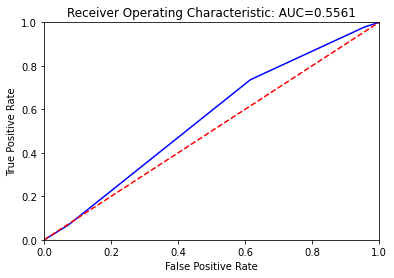

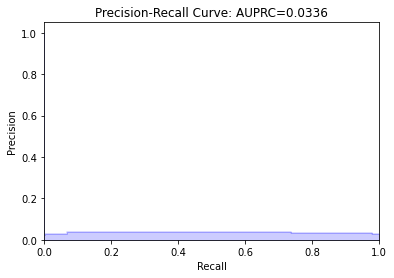

In [23]:
get_score_performance("triage_acuity", random_seed=random_seed)

Logistic Regression:


/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training time: 7.640365123748779 seconds
AUC: 0.6234410037596501
AUPRC: 0.05114005101351956
Sensitivity: 0.5866505830317652
Specificity: 0.58678410831645
Score thresold: 0.03030801430419689
2.5 97.5


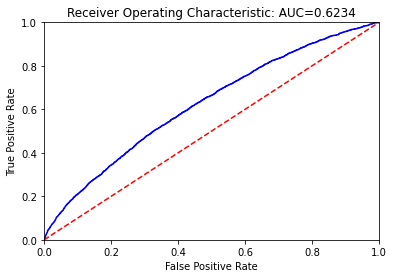

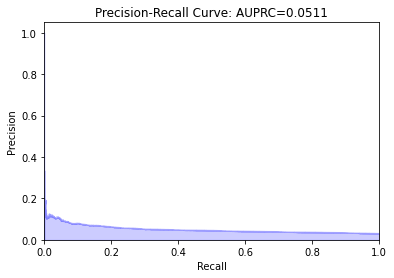

In [24]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 109.6709246635437 seconds
AUC: 0.5978043974638372
AUPRC: 0.05589117702788916
Sensitivity: 0.5170888620828307
Specificity: 0.6275139595789889
Score thresold: 0.04
2.5 97.5


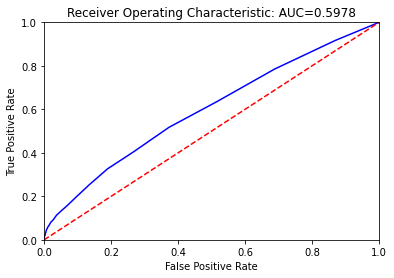

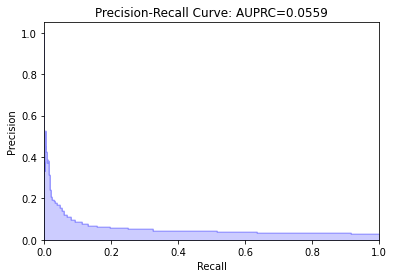

[0.13944544 0.11151851 0.01912782 0.0407845  0.09520952 0.05087113
 0.02021048 0.         0.00747831 0.01119225 0.00626262 0.00054553
 0.00633712 0.00336704 0.00490271 0.00466817 0.00258635 0.00388177
 0.00830894 0.00371632 0.00368557 0.00494988 0.00955745 0.00638878
 0.00593788 0.0015959  0.00566308 0.00740807 0.00497823 0.00846374
 0.00208901 0.00572556 0.00507346 0.00455505 0.00367937 0.09587618
 0.10906039 0.05138941 0.05448733 0.06902111]


In [25]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 99.93767309188843 seconds
AUC: 0.653771986718146
AUPRC: 0.06363413023401557
Sensitivity: 0.6308805790108565
Specificity: 0.5853016751494786
Score thresold: 0.028717911728702163
2.5 97.5


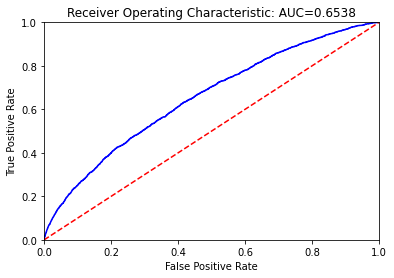

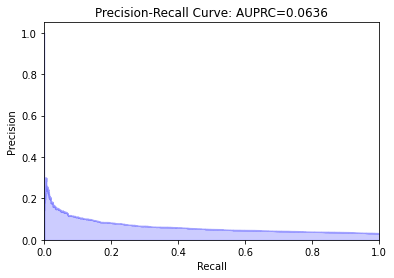

In [26]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

score_NEWS
AUC: 0.4997845345681419
AUPRC: 0.029222553433852293
Sensitivity: 0.48934459187776436
Specificity: 0.5218535356031032
Score thresold: 3
2.5 97.5


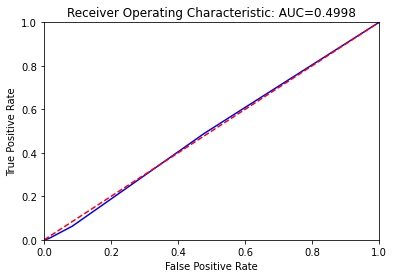

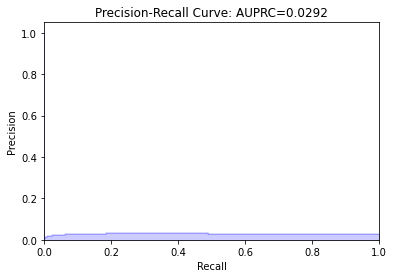

In [27]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5038754967546912
AUPRC: 0.02952135728653478
Sensitivity: 0.4583835946924005
Specificity: 0.5605326876513317
Score thresold: 3
2.5 97.5


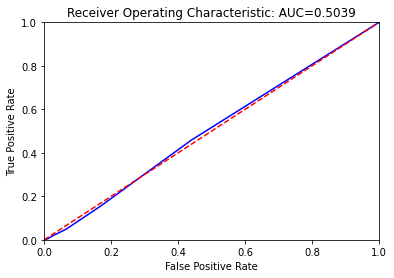

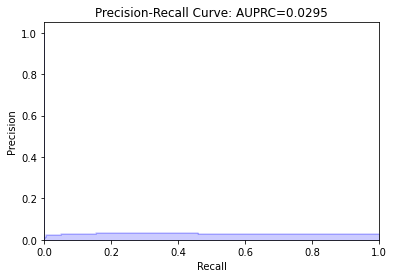

In [28]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.4561059655785019
AUPRC: 0.026668116893466685
Sensitivity: 0.5018094089264173
Specificity: 0.42628601077234773
Score thresold: 3
2.5 97.5


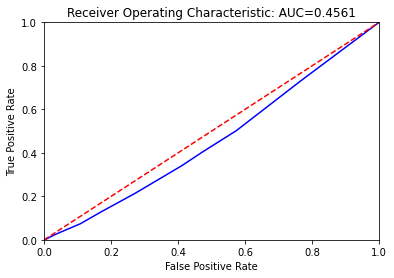

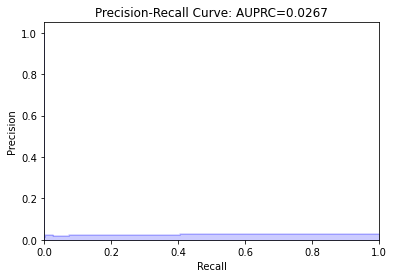

In [29]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.505342059482149
AUPRC: 0.030033275175049876
Sensitivity: 0.2440691596300764
Specificity: 0.7606117507535701
Score thresold: 4
2.5 97.5


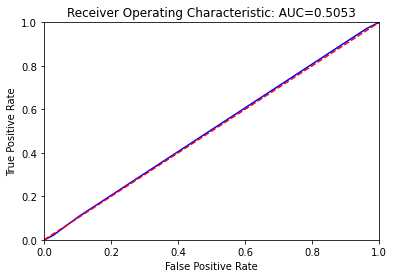

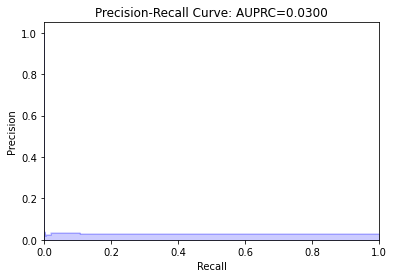

In [30]:
get_score_performance("score_MEWS", random_seed=random_seed)

In [31]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

### 4. Performance output

In [32]:
#result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv('result_72h_ed_revivist_disposition.csv')
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv('task3.csv')
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,triage_acuity,3.000,0.556 (0.55-0.563),0.034 (0.032-0.034),0.736 (0.722-0.747),0.384 (0.381-0.386),0.000
1,LR,0.030,0.623 (0.616-0.63),0.051 (0.05-0.053),0.587 (0.561-0.619),0.587 (0.555-0.622),7.640
2,RF,0.040,0.598 (0.59-0.607),0.056 (0.051-0.059),0.517 (0.506-0.532),0.628 (0.626-0.632),109.671
3,GB,0.029,0.654 (0.647-0.662),0.064 (0.061-0.067),0.631 (0.592-0.651),0.585 (0.582-0.617),99.938
4,score_NEWS,3.000,0.5 (0.49-0.504),0.029 (0.028-0.03),0.489 (0.469-0.498),0.522 (0.518-0.525),0.000
5,score_NEWS2,3.000,0.504 (0.494-0.507),0.03 (0.028-0.03),0.458 (0.438-0.466),0.561 (0.556-0.563),0.000
6,score_REMS,3.000,0.456 (0.442-0.464),0.027 (0.026-0.028),0.502 (0.388-0.51),0.426 (0.424-0.527),0.000
7,score_MEWS,4.000,0.505 (0.499-0.514),0.03 (0.029-0.031),0.244 (0.233-0.258),0.761 (0.758-0.763),0.000


In [33]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv('importances_72h_ed_revisit_disposition.csv')
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,triage_MAP,0.139445
1,age,0.111519
36,ed_heartrate_last_recoded,0.109060
35,ed_temperature_last_recoded,0.095876
4,intime_ed_hour,0.095210
39,n_medrecon,0.069021
38,ed_o2sat_last_recoded,0.054487
37,ed_resprate_last_recoded,0.051389
5,triage_pain_recoded,0.050871
3,score_CCI,0.040784


In [34]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('72h_ed_revisit_mlp')

2022-08-19 22:08:32.764621: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 22:08:32.764984: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: inputs=        triage_MAP   age  gender  score_CCI  intime_ed_hour  \
84341    93.333336  27.0     0.0        3.0             9.0   
368628   67.666664  53.0     1.0        4.0            18.0   
29489    87.666664  74.0     1.0        3.0            14.0   
343450   74.000000  58.0     1.0        3.0             8.0   
141387  102.000000  82.0     1.0        4.0            11.0   
...            ...   ...     ...        ...             ...   
139871  112.333336  52.0     0.0        1.0            14.0   
99093    93.333336  59.0     1.0        8.0            19.0   
7132     80.666664  38.0     0.0        0.0            11.0   
97139    92.000000  36.0     0.0        0.0            16.0   
32357    82.000000  46.0     0.0        0.0            22.0   

        triage_pain_recoded  triage_acuity  ed_los  chiefcom_chest_pain  \
84341                   7.0            3.0     0.0                  0.0   
368628                  0.0            2.0     0.0                  0.0   
29489                   0.0            2.0     0.0                  0.0   
343450                  6.0            3.0     0.0                  0.0   
141387                  0.0            1.0     0.0                  0.0   
...                     ...            ...     ...                  ...   
139871                  0.0            2.0     0.0                  0.0   
99093                   0.0            2.0     0.0                  0.0   
7132                    7.0            3.0     0.0                  0.0   
97139                  10.0            2.0     0.0                  0.0   
32357                   7.0            2.0     0.0                  1.0   

        chiefcom_abdominal_pain  chiefcom_headache  \
84341                       0.0                0.0   
368628                      0.0                0.0   
29489                       0.0                0.0   
343450                      0.0                0.0   
141387                      0.0                0.0   
...                         ...                ...   
139871                      0.0                0.0   
99093                       0.0                0.0   
7132                        0.0                1.0   
97139                       1.0                0.0   
32357                       0.0                0.0   

        chiefcom_shortness_of_breath  chiefcom_back_pain  chiefcom_cough  \
84341                            0.0                 0.0             0.0   
368628                           0.0                 0.0             0.0   
29489                            0.0                 0.0             0.0   
343450                           0.0                 0.0             0.0   
141387                           0.0                 0.0             0.0   
...                              ...                 ...             ...   
139871                           0.0                 0.0             0.0   
99093                            0.0                 0.0             1.0   
7132                             0.0                 0.0             0.0   
97139                            0.0                 0.0             0.0   
32357                            0.0                 0.0             0.0   

        chiefcom_nausea_vomiting  chiefcom_fever_chills  chiefcom_syncope  \
84341                        0.0                    0.0               0.0   
368628                       0.0                    0.0               0.0   
29489                        0.0                    0.0               0.0   
343450                       0.0                    0.0               0.0   
141387                       0.0                    0.0               0.0   
...                          ...                    ...               ...   
139871                       0.0                    0.0               0.0   
99093                        0.0                    0.0               0.0   
7132                         0.0                    0.0               0.0   
97139                        0.0                    0.0               0.0   
32357                        0.0                    0.0               0.0   

        chiefcom_dizziness  eci_Arrhythmia  eci_Valvular  eci_PHTN  eci_HTN1  \
84341                  0.0             1.0           0.0       0.0       0.0   
368628                 0.0             1.0           0.0       1.0       0.0   
29489                  0.0             0.0           0.0       0.0       0.0   
343450                 0.0             0.0           0.0       0.0       0.0   
141387                 0.0             0.0           0.0       0.0       0.0   
...                    ...             ...           ...       ...       ...   
139871                 0.0             0.0           0.0       0.0       0.0   
99093                  0.0             0.0           0.0       0.0       1.0   
7132                   0.0             0.0           0.0       0.0       0.0   
97139                  0.0             0.0           0.0       0.0       0.0   
32357                  0.0             0.0           0.0       0.0       0.0   

        eci_HTN2  eci_NeuroOther  eci_Hypothyroid  eci_Lymphoma  \
84341        0.0             0.0              0.0           0.0   
368628       0.0             1.0              0.0           0.0   
29489        0.0             0.0              0.0           0.0   
343450       1.0             0.0              0.0           0.0   
141387       0.0             0.0              0.0           0.0   
...          ...             ...              ...           ...   
139871       0.0             0.0              0.0           0.0   
99093        0.0             0.0              0.0           0.0   
7132         0.0             0.0              0.0           0.0   
97139        0.0             0.0              0.0           0.0   
32357        0.0             0.0              0.0           0.0   

        eci_Coagulopathy  eci_Obesity  eci_WeightLoss  eci_FluidsLytes  \
84341                0.0          0.0             0.0              0.0   
368628               0.0          0.0             0.0              1.0   
29489                0.0          0.0             0.0              0.0   
343450               0.0          0.0             0.0              0.0   
141387               0.0          0.0             0.0              0.0   
...                  ...          ...             ...              ...   
139871               0.0          0.0             0.0              0.0   
99093                1.0          1.0             1.0              1.0   
7132                 0.0          0.0             0.0              0.0   
97139                1.0          0.0             0.0              0.0   
32357                0.0          0.0             0.0              0.0   

        eci_BloodLoss  eci_Anemia  eci_Alcohol  eci_Drugs  eci_Psychoses  \
84341             0.0         0.0          0.0        0.0            0.0   
368628            0.0         0.0          0.0        0.0            0.0   
29489             0.0         0.0          0.0        0.0            0.0   
343450            0.0         1.0          0.0        0.0            0.0   
141387            0.0         0.0          0.0        0.0            0.0   
...               ...         ...          ...        ...            ...   
139871            0.0         0.0          0.0        0.0            0.0   
99093             0.0         1.0          0.0        0.0            0.0   
7132              0.0         0.0          0.0        0.0            0.0   
97139             0.0         0.0          0.0        0.0            0.0   
32357             0.0         0.0          0.0        0.0            0.0   

        ed_temperature_last_recoded  ed_heartrate_last_recoded  \
84341                     98.500000                       82.0   
368628                    99.400002                       88.0   
29489                     97.599998                       93.0   
343450                    98.000000                       70.0   
141387                    98.199997                       98.0   
...                             ...                        ...   
139871                    98.900002                       89.0   
99093                     97.599998                       85.0   
7132                      98.300003                       78.0   
97139                     98.099998                       78.0   
32357                     98.099998                       58.0   

        ed_resprate_last_recoded  ed_o2sat_last_recoded  n_medrecon  
84341                       14.0                   99.0         7.0  
368628                      26.0                   99.0        22.0  
29489                       16.0                   92.0        13.0  
343450                      16.0                   99.0         1.0  
141387                      19.0                   98.0         4.0  
...                          ...                    ...         ...  
139871                      18.0                   95.0         2.0  
99093                       20.0                   99.0        15.0  
7132                        18.0                  100.0         1.0  
97139                       17.0                   98.0         0.0  
32357                       14.0                   95.0         2.0  

[333737 rows x 40 columns]